# Pocket EVALUATION
Evaluate the finetuned model using the pocket-wise metric: DCC.


## Activate venv
`source ~/cryptic-nn/src/fine-tuning/esmc-venv/bin/activate`

# Define model
Define the finetuning model.

In [1]:
### PREDICTION SOURCE CODE ###

import torch
from transformers import AutoTokenizer, EsmModel
import numpy as np
import torch.nn as nn
import os
import sys
sys.path.append('/home/skrhakv/cryptic-nn/src')
import finetuning_utils

torch.manual_seed(420)

ESM_MODEL_NAME = 'facebook/esm2_t36_3B_UR50D'
MAX_LENGTH = 1024
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTPUT_SIZE = 1
DROPOUT = 0.25
SEQUENCE_MAX_LENGTH = MAX_LENGTH - 2

MODEL_PATH = "/home/skrhakv/cryptic-nn/final-data/trained-models/multitask-finetuned-model-with-ligysis.pt"
DECISION_THRESHOLD = 0.7  # Threshold to consider a point as high score; see src/decision-thresholds.ipynb (https://github.com/skrhakv/cryptic-finetuning)


class FinetuneESM(nn.Module):
    def __init__(self, esm_model: str) -> None:
        super().__init__()
        self.llm = EsmModel.from_pretrained(esm_model)
        self.dropout = nn.Dropout(DROPOUT)
        self.classifier = nn.Linear(self.llm.config.hidden_size, OUTPUT_SIZE)
        self.plDDT_regressor = nn.Linear(self.llm.config.hidden_size, OUTPUT_SIZE)
        self.distance_regressor = nn.Linear(self.llm.config.hidden_size, OUTPUT_SIZE)

    def forward(self, batch: dict[str, np.ndarray]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        input_ids, attention_mask = batch["input_ids"], batch["attention_mask"]
        token_embeddings = self.llm(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        return (
            self.classifier(token_embeddings),
            self.plDDT_regressor(token_embeddings),
            self.distance_regressor(token_embeddings),
        )


def compute_prediction(sequence: str, emb_path: str) -> np.ndarray:
    """
    Compute the residue-level prediction using the CryptoBench model.

    Args:
        sequence (str): Sequence of amino acids to be predicted.

    Returns:
        np.ndarray: The predicted scores for each residue.
    """
    model = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=False)

    tokenizer = AutoTokenizer.from_pretrained(ESM_MODEL_NAME)
    model.eval()

    sequence = str(sequence)
    all_embeddings = []
    final_output = []

    # Process sequence in chunks of SEQUENCE_MAX_LENGTH
    for i in range(0, len(sequence), SEQUENCE_MAX_LENGTH):
        processed_sequence = sequence[i : i + SEQUENCE_MAX_LENGTH]

        tokenized = tokenizer(
            processed_sequence, max_length=MAX_LENGTH, padding="max_length", truncation=True, return_tensors="pt"
        )
        tokenized = {k: v.to(DEVICE) for k, v in tokenized.items()}

        # embeddings
        with torch.no_grad():
            llm_output = model.llm(input_ids=tokenized["input_ids"], attention_mask=tokenized["attention_mask"])
            embeddings = llm_output.last_hidden_state  # shape: (1, seq_len, hidden_dim)

        embeddings_np = embeddings.squeeze(0).detach().cpu().numpy()
        mask = tokenized["attention_mask"].squeeze(0).detach().cpu().numpy().astype(bool)
        embeddings_np = embeddings_np[mask][1:-1]  # exclude [CLS], [SEP]
        all_embeddings.append(embeddings_np)

        # prediction
        with torch.no_grad():
            output, _, _ = model(tokenized)

        output = output.squeeze(0)
        mask = tokenized["attention_mask"].squeeze(0).bool()
        output = output[mask][1:-1]  # exclude [CLS], [SEP]

        probabilities = torch.sigmoid(output).detach().cpu().numpy()
        final_output.extend(probabilities)

    # save the concatenated embeddings for the entire sequence
    final_embeddings = np.concatenate(all_embeddings, axis=0)
    save_path = os.path.join(emb_path)
    np.save(save_path, final_embeddings)

    return np.array(final_output).flatten()

## COPYRIGHT NOTICE
The following code cell was inspired from the following repository: https://github.com/luk27official/cryptoshow-benchmark/

For further info see the LICENSE file.

# Definitions
Define functions for clustering and smoothing.

In [2]:
PREDICTED_RESIDUE_RADIUS_DISTANCE_THRESHOLD = 10 # in Angstroms; for each predicted binding residue, we consider all residues within this distance as candidate residues for inclusion into the binding site
CANDIDATE_RESIDUE_SURROUNDING_RADIUS_THRESHOLD = 15 # in Angstroms; for each candidate residue that is considered for inclusion into the binding site, we define the surrounding binding site respresentation as 
                                                    # the mean of embeddings of all predicted binding residues within this distance

def process_single_sequence(structure_name: str, chain_id: str, binding_residues_indices: np.ndarray, embedding_path: str, distance_matrix: np.ndarray):
    id = structure_name.lower() + chain_id
    if not os.path.exists(embedding_path):
        raise FileNotFoundError(f'Embedding file for {id} not found in {embedding_path}')
    
    embedding = np.load(embedding_path)

    Xs = []
    idx = []
    
    candidate_residues_indices = set()
    
    for residue_idx in binding_residues_indices:
        close_residues_indices = np.where(distance_matrix[residue_idx] < PREDICTED_RESIDUE_RADIUS_DISTANCE_THRESHOLD)[0]
        close_binding_residues_indices = np.intersect1d(close_residues_indices, binding_residues_indices)

        candidate_residues_indices.update(set(list(close_residues_indices)) - set(list(binding_residues_indices)))

    for residue_idx in candidate_residues_indices:
        close_residues_indices = np.where(distance_matrix[residue_idx] < CANDIDATE_RESIDUE_SURROUNDING_RADIUS_THRESHOLD)[0]
        close_binding_residues_indices = np.intersect1d(close_residues_indices, binding_residues_indices)

        concatenated_embedding = np.concatenate((embedding[residue_idx], np.mean(embedding[close_binding_residues_indices], axis=0)))
        Xs.append(concatenated_embedding)
        idx.append(residue_idx)
        
    return np.array(Xs), np.array(idx)

def predict_single_sequence(Xs, idx, model_3):
    Xs = torch.tensor(Xs, dtype=torch.float32).to(DEVICE)
    idx = torch.tensor(idx, dtype=torch.int64).to(DEVICE)

    test_logits = model_3(Xs).squeeze()
    test_pred = torch.sigmoid(test_logits)

    return {'predictions': test_pred.detach().cpu().numpy(), 'indices': idx.detach().cpu().numpy()}

def compute_distance_matrix(coordinates: np.ndarray) -> np.ndarray:
    """
    Compute the pairwise distance matrix for a given set of coordinates.

    Args:
        coordinates (np.ndarray): A 2D array of shape (N, 3), where N is the number of points,
                                   and each row represents the (x, y, z) coordinates of a point.

    Returns:
        np.ndarray: A 2D array of shape (N, N), where the element at [i, j] represents the Euclidean
                    distance between the i-th and j-th points.
    """
    coordinates = np.array(coordinates)
    distance_matrix = np.linalg.norm(coordinates[:, np.newaxis] - coordinates[np.newaxis, :], axis=-1)
    return distance_matrix


SMOOTHING_DECISION_THRESHOLD = 0.4 # see src/C-optimize-smoother/classifier-for-cryptoshow.ipynb (https://github.com/skrhakv/cryptic-finetuning)
DROPOUT = 0.5
LAYER_WIDTH = 2048
ESM2_DIM = 2560
INPUT_DIM  = ESM2_DIM * 2

class CryptoBenchClassifier(nn.Module):
    def __init__(self, dim=LAYER_WIDTH, dropout=DROPOUT):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=INPUT_DIM, out_features=dim)
        self.dropout1 = nn.Dropout(dropout)

        self.layer_2 = nn.Linear(in_features=dim, out_features=dim)
        self.dropout2 = nn.Dropout(dropout)

        self.layer_3 = nn.Linear(in_features=dim, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.dropout2(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))

def compute_clusters(
    points: list[list[float]],
    prediction_scores: list[float],
):
    from sklearn.cluster import DBSCAN
    """
    Compute clusters based on the given points and prediction scores.

    Args:
        points (list[list[float]]): A list of points, where each point is a list of 3 coordinates [x, y, z].
        prediction_scores (list[float]): A list of prediction scores corresponding to each point.

    Returns:
        np.ndarray: An array of cluster labels for each point. Points with no cluster are labeled as -1.
    """
    
    prediction_scores = prediction_scores.reshape(-1, 1)
    stacked = np.hstack((points, prediction_scores))  # Combine coordinates with scores

    high_score_mask = stacked[:, 3] > DECISION_THRESHOLD
    high_score_points = stacked[high_score_mask][:, :3]  # Extract only (x, y, z) coordinates

    EPS = 5.0  # Max distance for neighbors
    MIN_SAMPLES = 3  # Min points to form a cluster

    # No pockets can be formed if there are not enough high score points.
    if len(high_score_points) < MIN_SAMPLES:
        return -1 * np.ones(len(points), dtype=int)

    dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
    labels = dbscan.fit_predict(high_score_points)

    # Initialize all labels to -1
    all_labels = -1 * np.ones(len(points), dtype=int)
    # Assign cluster labels to high score points
    all_labels[high_score_mask] = labels
    labels = all_labels

    return labels

### Load
Loading the smoothing classifier model.

In [3]:
SMOOTHING_MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/C-optimize-smoother/smoother.pt'
smoothing_model = torch.load(SMOOTHING_MODEL_PATH, weights_only=False)

### Compute
Predict the sequence, cluster the predictions and smoothen it.

In [ ]:
import sys
sys.path.append('/home/skrhakv/cryptoshow-analysis/src/B-evaluate-cryptoshow')
import eval_utils

COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/A-cluster-ligysis-data/coordinates'
EMBEDDINGS_DIR = '/home/skrhakv/cryptoshow-analysis/data/B-evaluate-cryptoshow/embeddings'
cryptic_binding_residues, sequences = eval_utils.read_test_binding_residues()

predicted_binding_sites = {}
prediction_scores = {}
for protein_id in sequences.keys():
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'
    
    # finetuned prediction
    prediction = compute_prediction(
        sequence,
        embeddings_path
    )
    prediction_scores[protein_id] = prediction
    
    # cluster predicted pockets
    coordinates = np.load(coordinates_path)
    clusters = compute_clusters(
        coordinates,
        prediction
    )

    # load distance matrix
    distance_matrix = compute_distance_matrix(coordinates)

    # enhance predicted pockets using the smoothing model
    predicted_binding_sites[protein_id] = []
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        cluster_residue_indices = np.where(clusters == cluster_label)[0]
        embeddings, indices = process_single_sequence(pdb_id, chain_id, cluster_residue_indices, embeddings_path, distance_matrix) 
        prediction = predict_single_sequence(embeddings, indices, smoothing_model)
        enhanced_residue_indices = np.concatenate((indices[prediction['predictions'] > SMOOTHING_DECISION_THRESHOLD], cluster_residue_indices))
        predicted_binding_sites[protein_id].append(enhanced_residue_indices)

### Residue-level stats
Take the predictions from the previous steps and calculate residue-level metrics: F1, MCC, ACC.

In [ ]:
actual = []
predicted = []

from sklearn import metrics
for protein_id in cryptic_binding_residues.keys():
    this_actual = np.zeros(len(sequences[protein_id]), dtype=int)
    for binding_site in cryptic_binding_residues[protein_id]:
        binding_site = [int(i.split('_')[1]) for i in binding_site]
        this_actual[binding_site] = 1
    this_predicted = np.zeros(len(sequences[protein_id]), dtype=int)
    for binding_site in predicted_binding_sites[protein_id]:
        this_predicted[binding_site] = 1
    predicted.append(this_predicted)
    actual.append(this_actual)

labels = np.concatenate(actual)
predictions = np.concatenate(predicted)

acc = metrics.accuracy_score(labels, predictions)
mcc = metrics.matthews_corrcoef(labels, predictions)
f1 = metrics.f1_score(labels, predictions, average='weighted')

print(acc, mcc, f1)

# ACC                MCC                 F1
# 0.9285225841281267 0.45744821711536815 0.9279191632095326  - with clustering and smoothing
# 0.9319596904804751 0.4961393895010758  0.9322347096744608  - without clustering and smoothing
# 0.9229980205146662 0.48906673975928316 0.9269531602777475  - with clustering without smoothing
# 0.8786395537160339 0.4482652961836764 0.8980359042250458   - old version of classifier with clustering without smoothing
# try old version of classifier


0.9285945654129926 0.455878939471634 0.9278459044017294


### No clustering/smoothing
Only predict using the sequence, without any clustering or smoothing. However, use the same evaluation pipeline.

In [ ]:
no_clustering_predicted = []
for protein_id in sequences.keys():
    pdb_id = protein_id[:4]
    chain_id = protein_id[4:]
    sequence = sequences[protein_id]
    embeddings_path = f'/home/skrhakv/cryptoshow-analysis/data/B-evaluate-cryptoshow/embeddings/{pdb_id}{chain_id}.npy'
    coordinates_path = f'/home/skrhakv/cryptoshow-analysis/data/A-cluster-ligysis-data/coordinates/{pdb_id}{chain_id}.npy'
    
    prediction = compute_prediction(
        sequence,
        embeddings_path
    )
    this_predicted = (prediction > DECISION_THRESHOLD).astype(int)
    no_clustering_predicted.append(this_predicted)
predictions = np.concatenate(no_clustering_predicted)

acc = metrics.accuracy_score(labels, predictions)
mcc = metrics.matthews_corrcoef(labels, predictions)
f1 = metrics.f1_score(labels, predictions, average='weighted')

print(acc, mcc, f1)
# the results are different than in the paper (Hidden in protein sequences: Predicting cryptic binding sites), because the test set is slightly different - the binding residues were completed by LIGYSIS

0.9319596904804751 0.4961393895010758 0.9322347096744608


### Pocket-level stats
Compute DCC and DCA.

In [5]:
def compute_center_distance(actual_points: np.ndarray, predicted_points: np.ndarray) -> float:
    """
    Compute the distance from the predicted pocket center to the expected pocket center.
    Args:
        actual_points (np.ndarray): Array of shape (N, 3) containing the coordinates of the actual binding residues.
        predicted_points (np.ndarray): Array of shape (M, 3) containing the coordinates of the predicted binding residues.
    Returns:
        float: The DCC value, which is the distance from the predicted pocket center to the ligand center.
    """
    expected_coords = predicted_points.mean(axis=0)
    actual_coords = actual_points.mean(axis=0)

    dist = np.linalg.norm(expected_coords - actual_coords)
    return dist

In [8]:
COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/A-cluster-ligysis-data/coordinates'

DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(cryptic_binding_residues, predicted_binding_sites, prediction_scores, COORDINATES_DIR)

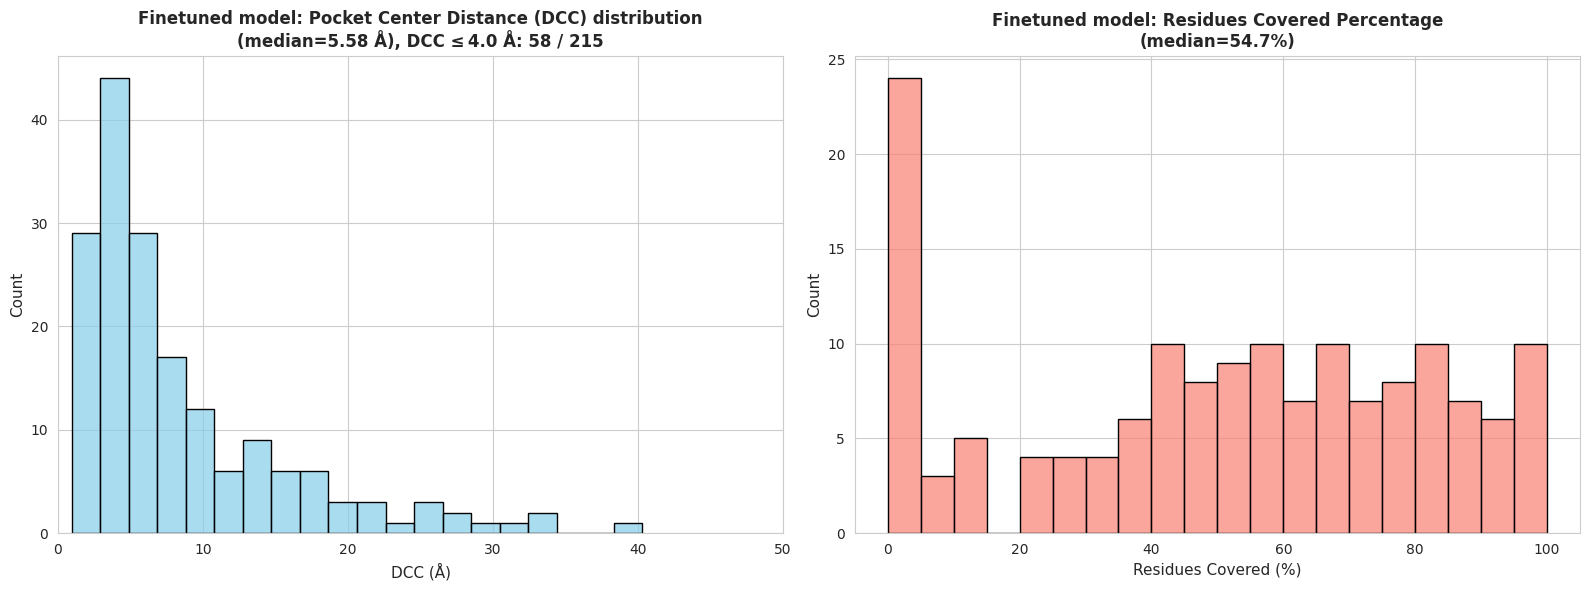

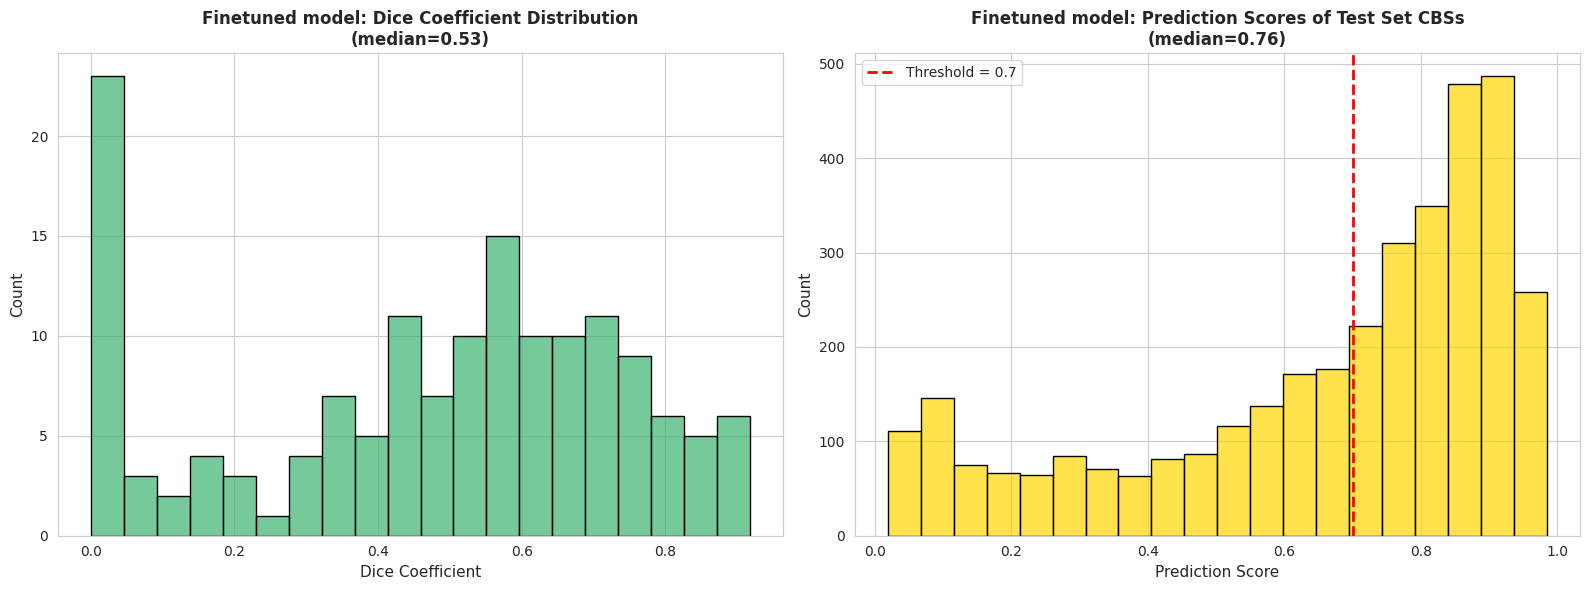

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

DCC_threshold = 4.0  # in Angstroms
MODEL = 'Finetuned model'

eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL)

## Combine predictions
Take predictions of p2rank and finetuned model, and combine them. Plot the results to see, whether the predictions are complementary or not.

In [11]:
import pickle
cryptic_binding_residues, sequences = eval_utils.read_test_binding_residues()

with open('/home/skrhakv/cryptoshow-analysis/data/B-evaluate-cryptoshow/predicted_pockets_p2rank.pkl', 'rb') as f:
    p2rank_predictions = pickle.load(f)
    # reformat in order to have the same format as predicted_binding_sites - dictionary of numpy arrays
    p2rank_predictions = {key:[np.array([int(ii[1:]) for ii in i]) for i in predicted_pockets] for key, predicted_pockets in p2rank_predictions.items()}

merged_predictions = {}
for protein_id in sequences.keys():
    merged_predictions[protein_id] = []
    # add finetuned model predictions
    for binding_sites in predicted_binding_sites[protein_id]:
        merged_predictions[protein_id].append(binding_sites)
    # add p2rank predictions
    for binding_sites in p2rank_predictions[protein_id]:
        merged_predictions[protein_id].append(binding_sites)


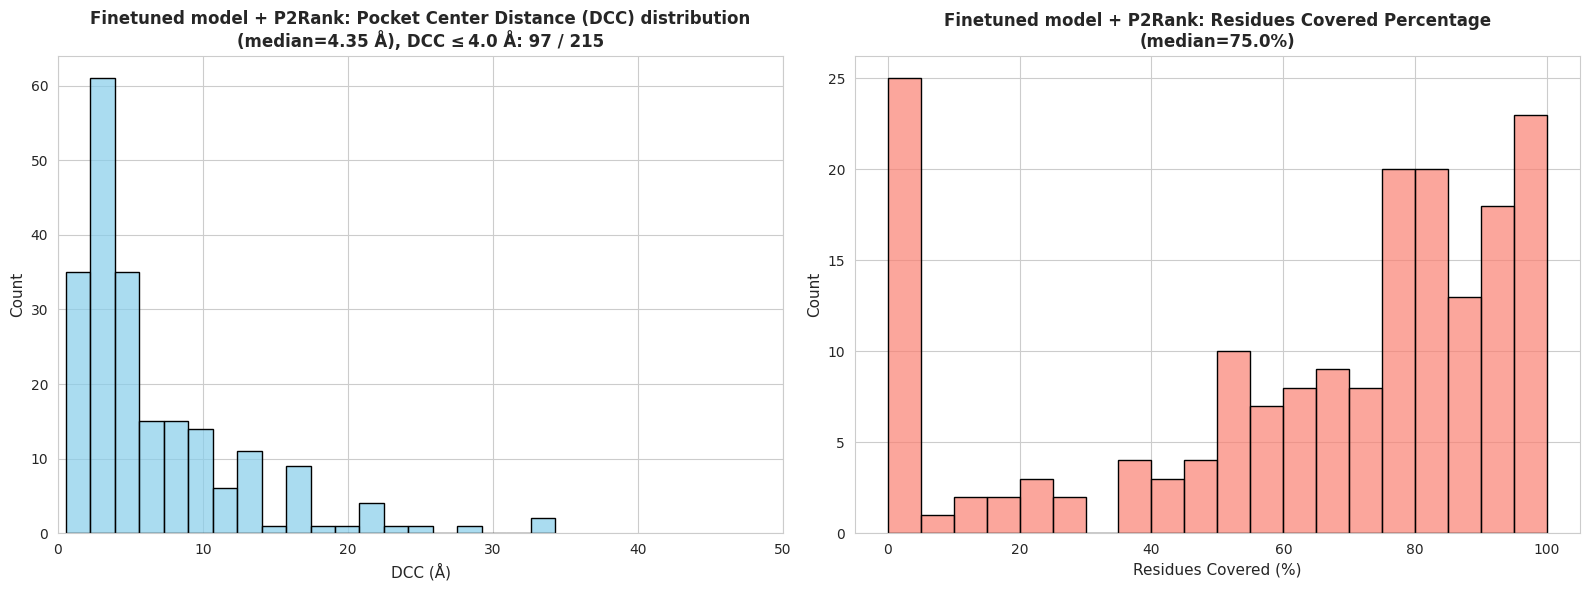

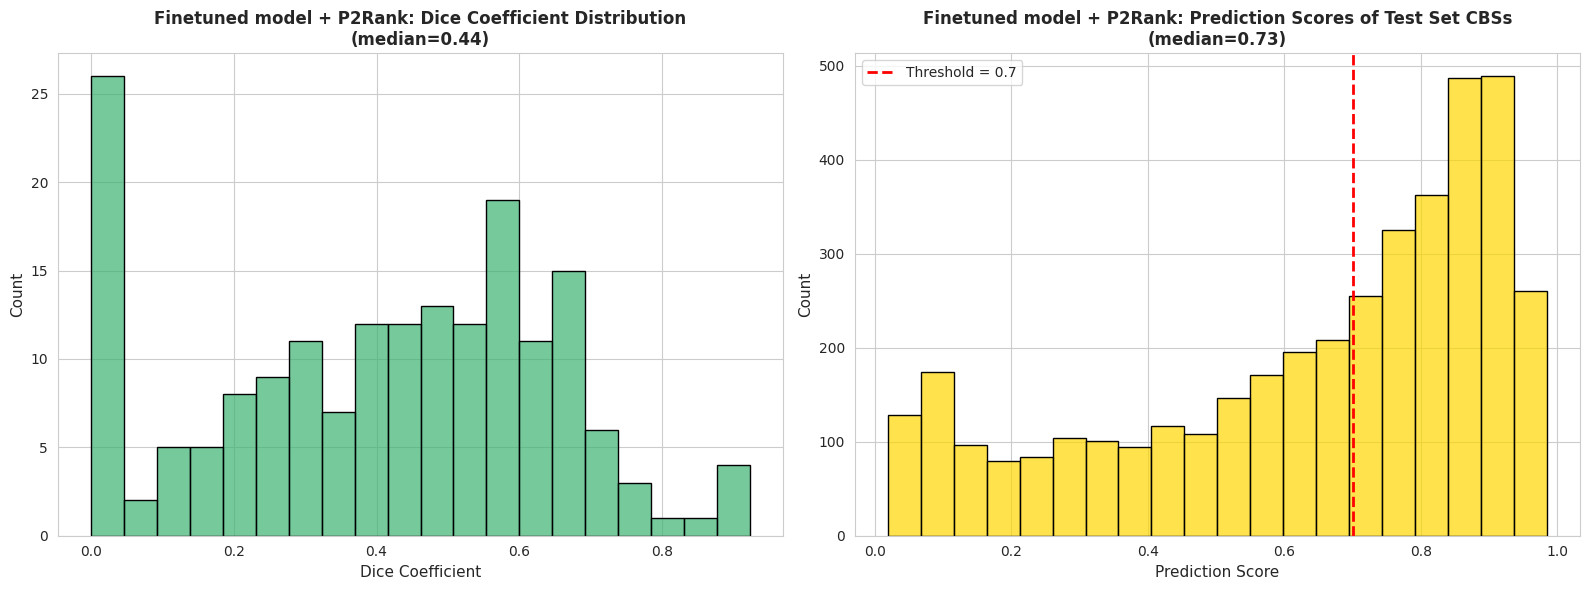

In [14]:
DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(cryptic_binding_residues, merged_predictions, prediction_scores, COORDINATES_DIR)

MODEL = 'Finetuned model + P2Rank'
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL)